# Ensemble sorting of a Neuropixels recording

This notebook reproduces figures 1 and 4 from the paper [**SpikeInterface, a unified framework for spike sorting**](https://www.biorxiv.org/content/10.1101/796599v2).

The data set for this notebook is available on the Dandi Archive: [https://gui.dandiarchive.org/#/dandiset/000034](https://gui.dandiarchive.org/#/dandiset/000034)

The entire data archive can be downloaded with the command `dandi download https://gui.dandiarchive.org/#/dandiset/000034/draft` (about 75GB).

Files required to run the code are:
- the raw data: [sub-mouse412804_ecephys.nwb](https://girder.dandiarchive.org/api/v1/item/5f2b250fee8baa608594a166/download)
- two manually curated sortings: 
    - [sub-mouse412804_ses-20200824T155542.nwb](https://girder.dandiarchive.org/api/v1/item/5f43c74cbf3ae27e069e0aee/download)
    - [sub-mouse412804_ses-20200824T155543.nwb](https://girder.dandiarchive.org/api/v1/item/5f43c74bbf3ae27e069e0aed/download)

These files should be in the same directory where the notebook is located (otherwise adjust paths below).

Author: [Matthias Hennig](http://homepages.inf.ed.ac.uk/mhennig/), University of Edinburgh, 24 Aug 2020

### Requirements

For this need you will need the following Python packages:

- numpy
- pandas
- matplotlib
- seaborn
- spikeinterface
- dandi
- matplotlib-venn

To run the MATLAB-based sorters, you would also need a MATLAB license.
For other sorters, please refer to the documentation on [how to install sorters](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html).

In [1]:
import os

# Matlab sorter paths:
# change these to match your environment
os.environ["IRONCLUST_PATH"] = "./ironclust"
os.environ["KILOSORT2_PATH"] = "./Kilosort2"
os.environ["HDSORT_PATH"] = "./HDsort"

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib_venn import venn3

import spikeinterface as si
import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from spikecomparison import GroundTruthStudy, MultiSortingComparison

%matplotlib inline

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
# print version information
si.print_spikeinterface_version()
ss.print_sorter_versions()

spikeinterface: 0.9.9
  * spikeextractor: 0.8.4
  * spiketoolkit: 0.6.3
  * spikesorters: 0.3.3
  * spikecomparison: 0.2.6
  * spikewidgets: 0.4.3

hdsort: version = '1.0.2'

herdingspikes: 0.3.7
ironclust: 5.9.8
kilosort2: git-48bf2b81d8ad
klusta: 3.0.16
mountainsort4: unknown
spykingcircus: 0.9.7
tridesclous: 1.6.0


In [2]:
# where to find the data set
data_file = Path('./') / 'mouse412804_probeC_15min.nwb'
# results are stored here
study_path = Path('./')
# this folder will contain all results
study_folder = study_path / 'study_15min/'
# this folder will be used as temorary space, and hold the sortings etc.
working_folder = study_path / 'working_15min'

# sorters to use
sorter_list = ['herdingspikes', 'kilosort2', 'ironclust', 'tridesclous', 'spykingcircus', 'hdsort']
# pass the following parameters to the sorters
sorter_params = {
#     'kilosort2': {'keep_good_only': True}, # uncomment this to test the native filter for false positives
    'spyking_circus': {'adjacency_radius': 50},
    'herdingspikes': {'filter': True, }}
sorter_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust','Tridesclous', 'SpykingCircus', 'HDSort']
sorter_names_short = ['HS', 'KS', 'IC', 'TDC', 'SC', 'HDS']

In [3]:
# create an extractor object for the raw data 
recording = se.NwbRecordingExtractor(str(data_file))

print("Number of frames: {}\nSampling rate: {}Hz\nNumber of channels: {}".format(
    recording.get_num_frames(), recording.get_sampling_frequency(), 
    recording.get_num_channels()))

Number of frames: 27000000
Sampling rate: 30000.0Hz
Number of channels: 248


# Run spike sorters and perform comparison between all outputs

In [4]:
# set up the study environment and run all sorters
# sorters are not re-run if outputs are found in working_folder 

if not study_folder.is_dir():
    print('Setting up study folder:', study_folder)
    os.mkdir(study_folder)

# run all sorters
result_dict = ss.run_sorters(sorter_list=sorter_list, recording_dict_or_list={'rec': recording}, with_output=True,
                             sorter_params=sorter_params, working_folder=working_folder, engine='loop', 
                             mode='keep', verbose=True)

# store sortings in a list for quick access
sortings = []
for s in sorter_list:
    sortings.append(result_dict['rec',s])

/disk/scratch/mhennig/miniconda3/envs/spikesorting/lib/python3.7/site-packages/spikeextractors/extractors/matsortingextractor/matsortingextractor.py:65: ResourceWarning: unclosed file <_io.BufferedReader name='/disk/scratch/mhennig/spikeinterface/Neuropixels_Allen/working_15min/rec/hdsort/hdsort_output/hdsort_output_results.mat'>
  raise ImportError("Version 7.2 .mat file given, but you don't have h5py installed.")


In [5]:
# perform a multi-comparison, all to all sortings
# result is stored, and loaded from disk if the file is found

if not os.path.isfile(study_folder / 'multicomparison.gpickle'):
    mcmp = sc.compare_multiple_sorters(sorting_list=sortings, name_list=sorter_names_short, 
                                       verbose=True)
    print('saving multicomparison')
    mcmp.dump(study_folder)
else:
    print('loading multicomparison')
    mcmp = sc.MultiSortingComparison.load_multicomparison(study_folder)

loading multicomparison
Multicomaprison step 3: clean graph
Removed edge ('IC_137', 'HS_49', {'weight': 0.552943287867911})
Removed edge ('KS_185', 'HDS_18005', {'weight': 0.6143539400371452})
Removed edge ('KS_295', 'HS_159', {'weight': 0.6111111111111112})
Removed edge ('KS_195', 'TDC_8', {'weight': 0.6909090909090909})
Removed 4 duplicate nodes
Multicomaprison step 4: extract agreement from graph


# Figure 1 - comparison of sorter outputs

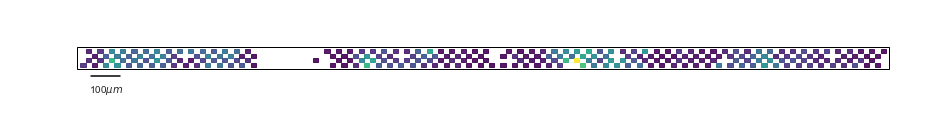

In [6]:
# activity levels on the probe

plt.figure(figsize=(16,2))
ax = plt.subplot(111)
w = sw.plot_activity_map(recording, trange=(0,20), transpose=True, ax=ax, background='w', frame=True)
ax.plot((50,150),(-30,-30),'k-')
ax.annotate('100$\\mu m$',(100,-90), ha='center');

(-2900, 19056.0)

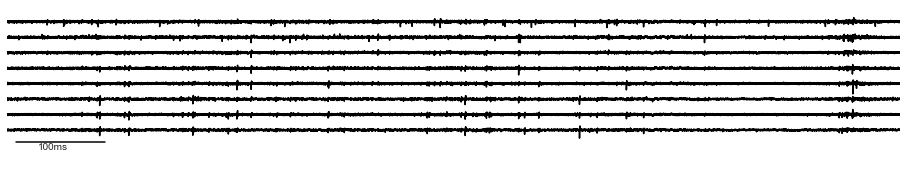

In [7]:
# example data traces

plt.figure(figsize=(16,6))
ax = plt.subplot(111)
w = sw.plot_timeseries(recording, channel_ids=range(20,28), color='k', ax=ax, trange=(1,2))
ax.axis('off')
p = ax.get_position()
p.y0 = 0.55
ax.set_position(p)
ax.set_xticks(())
ax.plot((1.01,1.11),(-1790,-1790),'k-')
ax.annotate('100ms',(1.051,-2900), ha='center');
ax.set_ylim((-2900,ax.set_ylim()[1]))

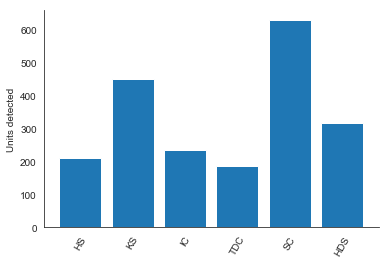

In [8]:
ax = plt.subplot(111)
ax.bar(range(len(sortings)), [len(s.get_unit_ids()) for s in sortings], color='tab:blue')
ax.set_xticks(range(len(sorter_names)))
ax.set_xticklabels(sorter_names_short, rotation=60, ha='center')
ax.set_ylabel('Units detected') 
clear_axes(ax)

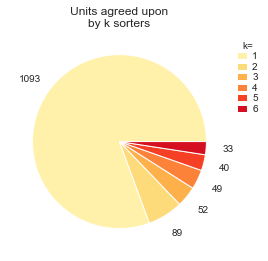

In [9]:
w = sw.plot_multicomp_agreement(mcmp, plot_type='pie')

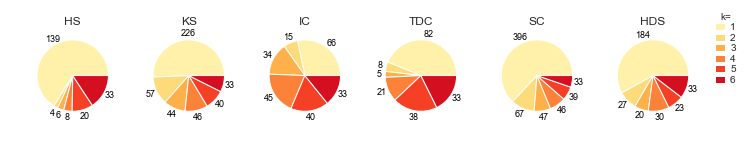

In [10]:
w = sw.plot_multicomp_agreement_by_sorter(mcmp, show_legend=True)


In [11]:
# numbers for figure above

print('number of units detected:')
for i,s in enumerate(sortings):
    print("{}: {}".format(sorter_names[i],len(s.get_unit_ids())))

sg_names, sg_units = mcmp.compute_subgraphs()
v, c = np.unique([len(np.unique(s)) for s in sg_names], return_counts=True)
df = pd.DataFrame(np.vstack((v,c,np.round(100*c/np.sum(c),2))).T,
             columns=('in # sorters','# units','percentage'))
print('\nall sorters, all units:')
print(df)
df = pd.DataFrame()
for i, name in enumerate(sorter_names_short):
    v, c = np.unique([len(np.unique(sn)) for sn in sg_names if name in sn], return_counts=True)
    df.insert(2*i,name,c)
    df.insert(2*i+1,name+'%',np.round(100*c/np.sum(c),1))
print('\nper sorter:')
print(df)

number of units detected:
HerdingSpikes: 210
Kilosort2: 448
Ironclust: 234
Tridesclous: 187
SpykingCircus: 628
HDSort: 317

all sorters, all units:
   in # sorters  # units  percentage
0           1.0   1093.0       80.60
1           2.0     89.0        6.56
2           3.0     52.0        3.83
3           4.0     49.0        3.61
4           5.0     40.0        2.95
5           6.0     33.0        2.43

per sorter:
    HS   HS%   KS   KS%  IC   IC%  TDC  TDC%   SC   SC%  HDS  HDS%
0  139  66.2  226  50.7  66  28.3   82  43.9  396  63.1  184  58.0
1    4   1.9   57  12.8  15   6.4    8   4.3   67  10.7   27   8.5
2    6   2.9   44   9.9  34  14.6    5   2.7   47   7.5   20   6.3
3    8   3.8   46  10.3  45  19.3   21  11.2   46   7.3   30   9.5
4   20   9.5   40   9.0  40  17.2   38  20.3   39   6.2   23   7.3
5   33  15.7   33   7.4  33  14.2   33  17.6   33   5.3   33  10.4


# Supplemental Figure - example unit templates

{'SC': 563, 'TDC': 3, 'HDS': 44005, 'HS': 5, 'KS': 116, 'IC': 88}
Agreement: 0.9661710270732794
{'HS': 49, 'TDC': 15, 'KS': 189, 'HDS': 18005, 'IC': 137, 'SC': 272}
Agreement: 0.6920718057618236


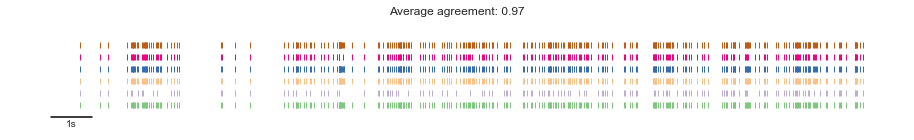

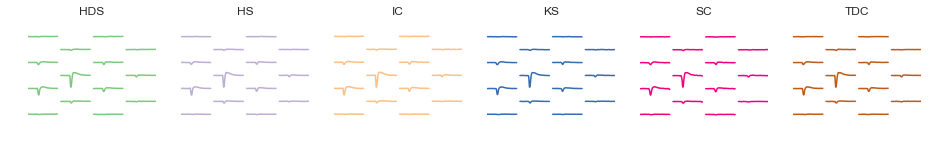

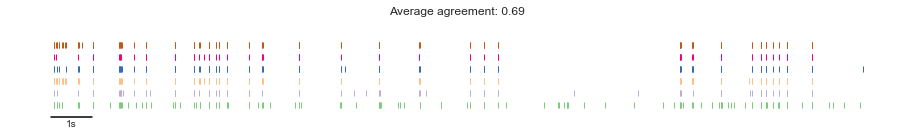

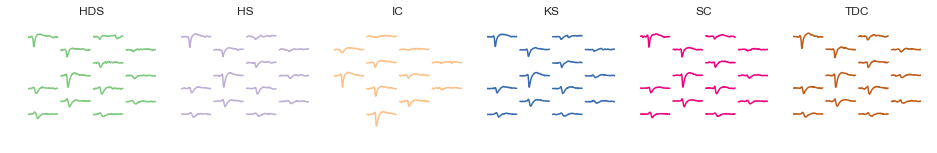

In [12]:
# show unit emplates and spike trains for two units/all sorters

sorting = mcmp.get_agreement_sorting(minimum_agreement_count=6)

get_sorting = lambda u: [mcmp.sorting_list[i] for i,n in enumerate(mcmp.name_list) if n==u[0]][0]
get_spikes = lambda u: [mcmp.sorting_list[i].get_unit_spike_train(u[1]) for i,n in enumerate(mcmp.name_list) if n==u[0]][0]


# one well matched and one not so well matched unit, all sorters
show_units = [2,17]

for i,unit in enumerate(show_units):
    fig = plt.figure(figsize=(16, 2))
    ax = plt.subplot(111)
    ax.set_title('Average agreement: {:.2f}'.format(sorting.get_unit_property(sorting.get_unit_ids()[unit],'avg_agreement')))
    units = sorting.get_unit_property(sorting.get_unit_ids()[unit], 'sorter_unit_ids')
    cols = plt.cm.Accent(np.arange(len(units))/len(units))
    for j,u in enumerate(dict(sorted(units.items())).items()):
        s = get_sorting(u).get_units_spike_train((u[1],))[0]
        s = s[s<20*get_sorting(u).get_sampling_frequency()]
        ax.plot(s/get_sorting(u).get_sampling_frequency(), np.ones(len(s))*j, '|', color=cols[j], label=u[0])
    ax.set_frame_on(False)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.plot((0,1),(-1,-1),'k')
    ax.annotate('1s',(0.5,-1.75), ha='center')
    ax.set_ylim((-2,len(units)+1))
    
    fig = plt.figure(figsize=(16, 2))
    units = sorting.get_unit_property(sorting.get_unit_ids()[unit], 'sorter_unit_ids')
    print(units)
    print('Agreement: {}'.format(sorting.get_unit_property(sorting.get_unit_ids()[unit],'avg_agreement')))
    cols = plt.cm.Accent(np.arange(len(units))/len(units))
    for j,u in enumerate(dict(sorted(units.items())).items()):
        ax = plt.subplot(1, len(sorter_list), j+1)
        w = sw.plot_unit_templates(recording, get_sorting(u), unit_ids=(u[1],), max_spikes_per_unit=10, 
                               channel_locs=True, radius=75, show_all_channels=False, color=[cols[j]], 
                               lw=1.5, ax=ax, plot_channels=False, set_title=False, axis_equal=True) 
        # was 100 spikes in original plot
        ax.set_title(u[0])

# Figure 4 - comparsion between ensembe sortings and curated data

In [13]:
# perform a comparison with curated sortings (KS2)

curated1 = se.NwbSortingExtractor('sub-mouse412804_ses-20200824T155542.nwb', sampling_frequency=30000)
curated2 = se.NwbSortingExtractor('sub-mouse412804_ses-20200824T155543.nwb', sampling_frequency=30000)

comparison_curated = sc.compare_two_sorters(curated1, curated2)
comparison_curated_ks = sc.compare_multiple_sorters((curated1, curated2, sortings[sorter_list.index('kilosort2')]))

# consensus sortings (units where at least 2 sorters agree)
sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
consensus_sortings = []
units_dict = defaultdict(list)
units = [sorting.get_unit_property(u,'sorter_unit_ids') for u in sorting.get_unit_ids()]
for au in units:
    for u in au.items():
        units_dict[u[0]].append(u[1])
for i,s in enumerate(sorter_names_short):
    consensus_sortings.append(se.SubSortingExtractor(sortings[i], unit_ids=units_dict[s]))

# orphan units (units found by only one sorter)
sorting = mcmp.get_agreement_sorting(minimum_agreement_count=1, minimum_agreement_count_only=True)
unmatched_sortings = []
units_dict = defaultdict(list)
units = [sorting.get_unit_property(u,'sorter_unit_ids') for u in sorting.get_unit_ids()]
for au in units:
    for u in au.items():
        units_dict[u[0]].append(u[1])
for i,s in enumerate(sorter_names_short):
    unmatched_sortings.append(se.SubSortingExtractor(sortings[i], unit_ids=units_dict[s]))
    
consensus_curated_comparisons = []
for s in consensus_sortings:
    consensus_curated_comparisons.append(sc.compare_two_sorters(s, curated1))
    consensus_curated_comparisons.append(sc.compare_two_sorters(s, curated2))    
    
unmatched_curated_comparisons = []
for s in unmatched_sortings:
    unmatched_curated_comparisons.append(sc.compare_two_sorters(s, curated1))
    unmatched_curated_comparisons.append(sc.compare_two_sorters(s, curated2))

all_curated_comparisons = []
for s in sortings:
    all_curated_comparisons.append(sc.compare_two_sorters(s, curated1))
    all_curated_comparisons.append(sc.compare_two_sorters(s, curated2))    \
    
# count various types of units

count_mapped = lambda x : np.sum([u!=-1 for u in x.get_mapped_unit_ids()])
count_not_mapped = lambda x : np.sum([u==-1 for u in x.get_mapped_unit_ids()])
count_units = lambda x : len(x.get_unit_ids())

n_consensus_curated_mapped = np.array([count_mapped(c.get_mapped_sorting1()) for c in consensus_curated_comparisons]).reshape((len(sorter_list),2))
n_consensus_curated_unmapped = np.array([count_not_mapped(c.get_mapped_sorting1()) for c in consensus_curated_comparisons]).reshape((len(sorter_list),2))
n_unmatched_curated_mapped = np.array([count_mapped(c.get_mapped_sorting1()) for c in unmatched_curated_comparisons]).reshape((len(sorter_list),2))
n_all_curated_mapped = np.array([count_mapped(c.get_mapped_sorting1()) for c in all_curated_comparisons]).reshape((len(sorter_list),2))
n_all_curated_unmapped = np.array([count_not_mapped(c.get_mapped_sorting1()) for c in all_curated_comparisons]).reshape((len(sorter_list),2))
n_curated_all_unmapped = np.array([count_not_mapped(c.get_mapped_sorting2()) for c in all_curated_comparisons]).reshape((len(sorter_list),2))
n_all = np.array([count_units(s) for s in sortings])
n_consensus = np.array([count_units(s) for s in consensus_sortings])
n_unmatched = np.array([count_units(s) for s in unmatched_sortings])
n_curated1 = len(curated1.get_unit_ids())
n_curated2 = len(curated2.get_unit_ids())

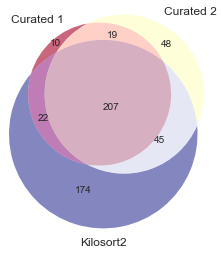

In [14]:
# overlap between two manually curated data and the Kilosort2 sorting they were derived from

i = {}
for k in ['{0:03b}'.format(v) for v in range(1,2**3)]:
    i[k] = 0
i['111'] = len(comparison_curated_ks.get_agreement_sorting(minimum_agreement_count=3).get_unit_ids())
s = comparison_curated_ks.get_agreement_sorting(minimum_agreement_count=2, minimum_agreement_count_only=True)
units = [s.get_unit_property(u,'sorter_unit_ids').keys() for u in s.get_unit_ids()]
for u in units:
    if 'sorting1' in u and 'sorting2' in u:
        i['110'] += 1
    if 'sorting1' in u and 'sorting3' in u:
        i['101'] += 1
    if 'sorting2' in u and 'sorting3' in u:
        i['011'] += 1   
s = comparison_curated_ks.get_agreement_sorting(minimum_agreement_count=1, minimum_agreement_count_only=True)
units = [s.get_unit_property(u,'sorter_unit_ids').keys() for u in s.get_unit_ids()]
for u in units:
    if 'sorting1' in u:
        i['100'] += 1
    if 'sorting2' in u:
        i['010'] += 1
    if 'sorting3' in u:
        i['001'] += 1   
colors = plt.cm.RdYlBu(np.linspace(0,1,3))
venn3(subsets = i,set_labels=('Curated 1', 'Curated 2', 'Kilosort2'), 
      set_colors=colors, alpha=0.6, normalize_to=100)

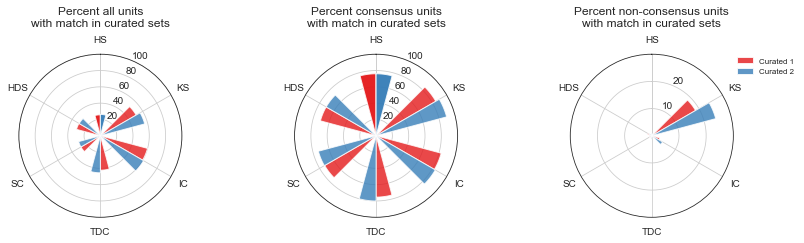

In [15]:
# overlaps betweem ensemble sortings (per sorter) and manually curated sortings

def plot_mcmp_results(data, labels, ax, ylim=None, yticks=None, legend=False):
    angles = (np.linspace(0, 2*np.pi, len(sorter_list), endpoint=False)).tolist()
    angles += angles[:1]
    for i,v in enumerate(data):
        v = v.tolist() + v[:1].tolist()
        ax.bar(np.array(angles)+i*2*np.pi/len(sorter_list)/len(data)/2-2*np.pi/len(sorter_list)/len(data)/4, 
               v, label=labels[i], 
               alpha=0.8, width=np.pi/len(sorter_list)/2)
        
    ax.set_thetagrids(np.degrees(angles), sorter_names_short)
    if legend:
        ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0., frameon=False, fontsize=8, markerscale=0.25)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticks(yticks)

plt.figure(figsize=(14,3))
sns.set_palette(sns.color_palette("Set1"))
ax = plt.subplot(131, projection='polar')
plot_mcmp_results((n_all_curated_mapped[:,0]/n_all*100, 
                   n_all_curated_mapped[:,1]/n_all*100), 
                  ('Curated 1','Curated 2'), ax, yticks=np.arange(20,101,20))
ax.set_title('Percent all units\nwith match in curated sets',pad=20);
plt.ylim((0,100))

ax = plt.subplot(132, projection='polar')
plot_mcmp_results((n_consensus_curated_mapped[:,0]/n_consensus*100, 
                   n_consensus_curated_mapped[:,1]/n_consensus*100), 
                  ('Curated 1','Curated 2'), ax, yticks=np.arange(20,101,20))
ax.set_title('Percent consensus units\nwith match in curated sets',pad=20);
plt.ylim((0,100))

ax = plt.subplot(133, projection='polar')
plot_mcmp_results((n_unmatched_curated_mapped[:,0]/n_unmatched*100, 
                   n_unmatched_curated_mapped[:,1]/n_unmatched*100), 
                  ('Curated 1','Curated 2'), ax, ylim=(0,30), yticks=np.arange(10,21,10), legend=True)
ax.set_title('Percent non-consensus units\nwith match in curated sets',pad=20);

In [16]:
# numbers for figure above

df = pd.DataFrame(np.vstack((n_all_curated_mapped[:,0]/n_all*100, n_all_curated_mapped[:,1]/n_all*100,
                           n_all_curated_mapped[:,0], n_all_curated_mapped[:,1])).T,
                  columns = ('C1 %', 'C2 %', 'C1', 'C2'), index=sorter_names_short)
print('Percent all units with match in curated sets')
print(df)

df = pd.DataFrame(np.vstack((n_consensus_curated_mapped[:,0]/n_consensus*100, n_consensus_curated_mapped[:,1]/n_consensus*100,
                           n_consensus_curated_mapped[:,0],n_consensus_curated_mapped[:,1])).T,
                  columns = ('C1 %', 'C2 %', 'C1', 'C2'), index=sorter_names_short)
print('\nPercent consensus units with match in curated sets')
print(df)

df = pd.DataFrame(np.vstack((n_unmatched_curated_mapped[:,0]/n_unmatched*100,
                             n_unmatched_curated_mapped[:,1]/n_unmatched*100,
                           n_unmatched_curated_mapped[:,0],n_unmatched_curated_mapped[:,1])).T,
                  columns = ('C1 %', 'C2 %', 'C1', 'C2'), index=sorter_names_short)
print('\nPercent non-consensus units with match in curated sets')
print(df)

Percent all units with match in curated sets
          C1 %       C2 %     C1     C2
HS   25.714286  26.190476   54.0   55.0
KS   50.669643  56.250000  227.0  252.0
IC   59.829060  61.111111  140.0  143.0
TDC  42.245989  45.454545   79.0   85.0
SC   27.547771  27.547771  173.0  173.0
HDS  30.283912  29.968454   96.0   95.0

Percent consensus units with match in curated sets
          C1 %       C2 %     C1     C2
HS   76.056338  76.056338   54.0   54.0
KS   84.545455  89.545455  186.0  197.0
IC   82.634731  83.832335  138.0  140.0
TDC  75.238095  80.000000   79.0   84.0
SC   72.844828  73.275862  169.0  170.0
HDS  70.676692  70.676692   94.0   94.0

Percent non-consensus units with match in curated sets
          C1 %       C2 %    C1    C2
HS    0.000000   0.719424   0.0   1.0
KS   18.584071  24.336283  42.0  55.0
IC    3.030303   4.545455   2.0   3.0
TDC   0.000000   1.219512   0.0   1.0
SC    1.010101   0.757576   4.0   3.0
HDS   1.630435   1.086957   3.0   2.0
